# Machine learning applied to predicting stocks performance
## Introduction
The goal with this project is to use machine learning models to attempt to predict which factors most influence the performance of a stock. Since the stock market is a highly complex system (and chaotic) by nature, I won't try to make regression predictions (such as individual returns for each stock), but rather try and predict which stocks can be classified as "Overperformers", i.e., which stocks are able to beat the historical market average, which is [around 10% for the past 50 years](https://www.investopedia.com/ask/answers/042415/what-average-annual-return-sp-500.asp). This project is, therefore, a classification problem, not regression.

## Background
Investing in the stock market can be roughly split into two broad categories: active and passive investing. Passive investing can be seen as taking out the guesswork and extra work involved in picking stocks and, instead, select a mutual fund or index fund to invest in. This means selecting a basket of stocks as a whole, which reduces risk and time spent investigating each company.  

Active investing means selecting individual financial instruments (stocks, bonds, mutual/hedge funds, derivatives, etc.). For simplification, I will only consider stocks for this analysis, and only stocks that belong to the Russell 1000 index (meaning, the 1000 American companies with the most value in the market (market capitalization)).

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import requests
import datetime as dt
from yahooquery import Ticker
import matplotlib.pyplot as plt

# set display options
pd.options.display.max_columns = 100
pd.options.display.max_rows = 30

## Data collection: stock fundamental information
Within the active investing category, there are two main investing styles: technical and fundamental analysis. Technical analysis is a trading discipline employed to evaluate investments and identify trading opportunities by analyzing statistical trends gathered from trading activity, such as price movement, volume, and price trends, among others. 
For my analysis, I will employ fundamental analysis, with metrics that attempt to measure company performance (such as earnings), company financial health (such as the amount of debt compared to the amount of equity), and several types of stock yields, such as dividends, buyback, and the addition of both (shareholder yield).

In [2]:
# Function to collect the list of Russell 1000 tickers
def get_russell_1000_tickers():
    url = "https://en.wikipedia.org/wiki/Russell_1000_Index"
    html = requests.get(url).text
    # Adjust the index depending on the table structure
    russell_1000_data = pd.read_html(html)[2]
    russell_1000_data['Ticker'] = russell_1000_data['Ticker'].str.replace(
        ".", "-")
    tickers = russell_1000_data['Ticker'].tolist()
    return tickers


# Function to get the financial data for each stock
def get_financial_data(tickers):
    data = {}
    for ticker in tickers:
        stock = Ticker(ticker)

        try:
            # gather statements
            income_statement = stock.income_statement(
                frequency='a', trailing=True
            )
            # only select year 2022
            income_statement = income_statement[
                income_statement['asOfDate'].dt.year == 2022
            ]

            balance_sheet = stock.balance_sheet(
                frequency='q', trailing=False
            )

            '''
            balance sheet doesn't require filtering for only year 2022
            because I am using quarterly data (which is more accurate than annual data) because assets shouldn't be evaluated on a yearly basis, but rather on the latest available info
            '''

            # only select year 2022
            cash_flow = stock.cash_flow(
                frequency='a', trailing=True
            )

            cash_flow = cash_flow[
                cash_flow['asOfDate'].dt.year == 2022
            ]

            market_cap = stock.valuation_measures['MarketCap'].dropna().iloc[0]
            price_prev = stock.history(period='1y', interval='1wk')['close'][0]
            # since the period is 1 year, the first row will be last year, and the last will be current year
            price_curr = stock.history(period='1y', interval='1wk')[
                'close'][-1]
            revenue = income_statement['TotalRevenue'][0]
            fcf = cash_flow['FreeCashFlow'][0]
            net_income = income_statement['NetIncome'][0]
            equity = balance_sheet['StockholdersEquity'].dropna().iloc[0]
            liabilities = balance_sheet['TotalLiabilitiesNetMinorityInterest'].dropna(
            ).iloc[0]
            total_debt = balance_sheet['TotalDebt'].dropna().iloc[0]

            # Step 3: Calculate the valuation metrics
            try:
                cash_and_equivalents = balance_sheet['CashCashEquivalentsAndShortTermInvestments'].dropna(
                ).iloc[0]

                ev = market_cap + total_debt - cash_and_equivalents

                op_income = income_statement['OperatingIncome'][0]

            except:
                cash_and_equivalents = balance_sheet['CashAndCashEquivalents'].dropna(
                ).iloc[0]

                ev = market_cap + total_debt - cash_and_equivalents

                op_income = income_statement['PretaxIncome'][0]

            ebit_to_ev = op_income / ev

            fcf_to_ev = fcf / ev

            sales_to_ev = revenue / ev

            e_to_ev = net_income / ev

            graham_test = (0 < (market_cap / net_income) <=
                           10) & ((equity >= liabilities))

            try:
                dividends_paid = cash_flow['CashDividendsPaid'][0] * -1
                dividend_yield = dividends_paid / market_cap * 100

            except:
                dividend_yield = 0

            try:
                buyback = cash_flow["RepurchaseOfCapitalStock"][0] * -1
                buyback_yield = buyback * 100 / market_cap

            except:
                buyback_yield = 0

            data[ticker] = {
                "EBIT/EV": ebit_to_ev,
                "FCF/EV": fcf_to_ev,
                "Sales/EV": sales_to_ev,
                "E/P": net_income / market_cap,
                "E/EV": net_income / ev,
                "Debt/Equity": total_debt / equity,
                "Passes Graham test": graham_test,
                "Enterprise Value (M)": round((ev / 1000000), 3),
                "Market cap (M)": round((market_cap / 1000000), 3),
                "Net income (M)": round((net_income / 1000000), 3),
                "Operating income (M)": round((op_income / 1000000), 3),
                "Dividend Yield (%)": dividend_yield,
                "Shareholder Yield (%)": dividend_yield + buyback_yield,
                "Buyback Yield (%)": buyback_yield,
                "price_prev": price_prev,
                "price_curr": price_curr
            }

        except Exception as e:
            print(f"Error processing {ticker}: {e}")
    return data

# Function to classify stocks based on performance, compared to market returns
# over 10% -> overperformer
# less than or equal to 10% -> underperformer


def performance(df):
    df.loc[(df['price_curr'] / df['price_prev'] > 1.1), 'overperformer'] = 1
    df.loc[(df['price_curr'] / df['price_prev'] <= 1.1), 'overperformer'] = 0
    df.drop(columns=['price_prev', 'price_curr'], inplace=True)
    return df

In [6]:
# gathering the data
tickers = get_russell_1000_tickers()
data = get_financial_data(tickers)
df = pd.DataFrame(data).T

# Add target column ('overperformer')
df = performance(df)

Error processing AM: 'CashAndCashEquivalents'
Error processing AR: 'CashAndCashEquivalents'
Error processing AZPN: index 0 is out of bounds for axis 0 with size 0
Error processing GNTX: 'TotalDebt'
Error processing GMED: 'TotalDebt'
Error processing ISRG: 'TotalDebt'
Error processing KD: index 0 is out of bounds for axis 0 with size 0
Error processing LLYVA: string indices must be integers, not 'str'
Error processing LLYVK: string indices must be integers, not 'str'
Error processing MPWR: 'TotalDebt'
Error processing MNST: 'TotalDebt'


/var/folders/7y/kdr8r5r10wv7bv7l86hns69m0000gn/T/ipykernel_2356/2691830308.py:101: RuntimeWarning: divide by zero encountered in scalar divide
  "Debt/Equity": total_debt / equity,


Error processing UAA: index 0 is out of bounds for axis 0 with size 0
Error processing UA: index 0 is out of bounds for axis 0 with size 0


In [ ]:
# export
df.reset_index(names='Ticker', inplace=True)
df.to_csv("stocks_data.csv", index=False) # exporting the data is useful to avoid re-running the API calls

In [5]:
# reading the data without running the API calls
df = pd.read_csv("stocks_data.csv")

## Preprocessing the data
To be able to predict which stocks are overperformers, the data has to be pre-processed first, before considering feature engineering or model selection.

### Converting columns to numbers
Since most machine learning models use mathematical functions, columns must be converted to numbers first.

In [9]:
# converting boolean classification into binary values
df['Passes Graham test'] = df['Passes Graham test'].astype(int)

# converting string columns into numerical
for col in df.drop(columns=['Ticker']).columns:
    df[col] = pd.to_numeric(df[col])

### Dealing with missing data

In [10]:
# Checking for empty values
df.isnull().sum()

Ticker                    0
EBIT/EV                   0
FCF/EV                    0
Sales/EV                  0
E/P                       0
E/EV                      0
Debt/Equity               0
Passes Graham test        0
Enterprise Value (M)      0
Market cap (M)            0
Net income (M)            0
Operating income (M)      0
Dividend Yield (%)       30
Shareholder Yield (%)    92
Buyback Yield (%)        65
overperformer             0
dtype: int64

Only 3 columns contain empty values. Considering 92 rows (Shareholder Yield (%)) is about 9% of the dataset, I will fill these values with the mean to avoid losing potentially important data.

In [11]:
# Filling empty values
df['Dividend Yield (%)'].fillna(df['Dividend Yield (%)'].mean(), inplace=True)
df['Shareholder Yield (%)'].fillna(
    df['Shareholder Yield (%)'].mean(), inplace=True
)
df['Buyback Yield (%)'].fillna(df['Buyback Yield (%)'].mean(), inplace=True)

## Scaling the data
Since some classification algorithms are distance-based, scaling the data is important to avoid having one feature dominating another. 
It also helps gradient descent converge faster if all features are on the same scale.

While initially scaling the data, I faced an error because there is one stock which has the metric 'Debt/Equity' equal to infinity (because equity is a value equal to zero or extremely small). This could happen because the value for liabilities is very close to the value of liabilities (or even equal), resulting in a high value (debt) being divided by an extremely small value (equity). 

Since this occurs in only one of the stocks, I will drop this row, which won't affect the result significantly.

In [12]:
to_drop = df[df['Debt/Equity'] == np.inf].index
df.drop(to_drop, inplace=True)

### Removing outliers
When screening stocks to build a portfolio, outliers in the data can disrupt later modeling. For example, if most stocks have a price-to-earnings ratio around 100 but one stock has a ratio of 1000, the large gap between that stock and the others would skew the data. To enable proper modeling, I remove outliers like stocks with unusually high or low financial ratios relative to the rest of the dataset. This cleaning step creates a more representative dataset for analysis.

### Visual exploratory analysis

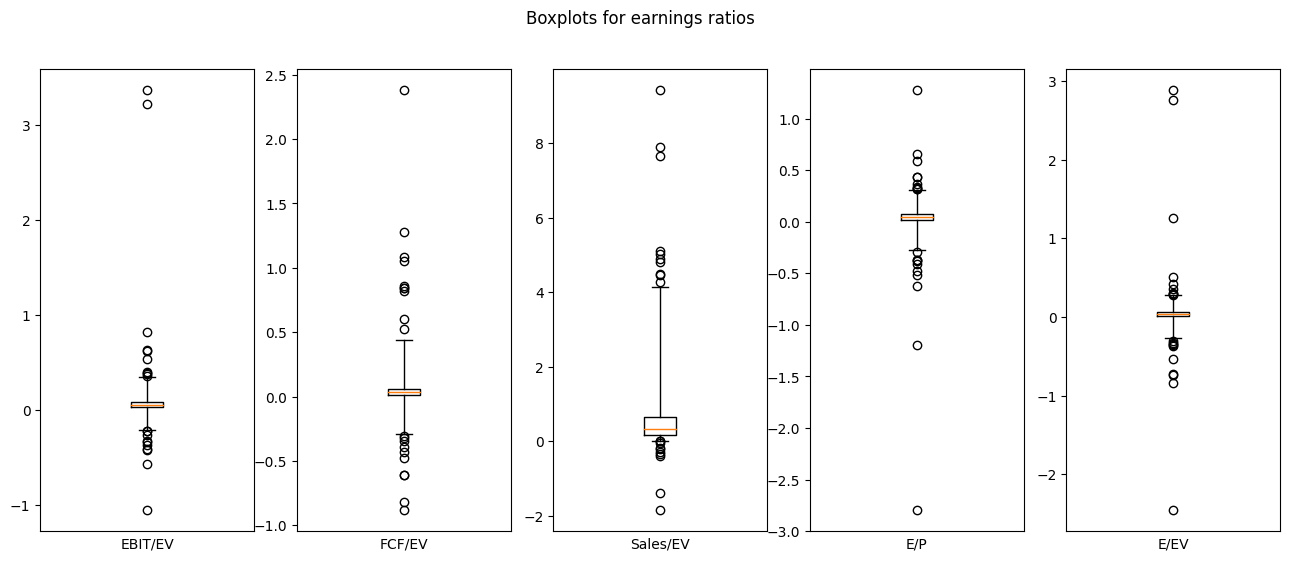

In [13]:
# create a figure and ax
fig, ax = plt.subplots(1, 5, figsize=(16,6))

# earnings ratios
e_ratios = [
    'EBIT/EV', 'FCF/EV', 'Sales/EV', 'E/P', 'E/EV'
]
for n in range(len(e_ratios)):
    ax[n].boxplot(df[e_ratios[n]], whis=(1,99)) # set the whiskers to top and lowest percentile
    ax[n].set_xlabel(e_ratios[n])
    ax[n].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)

fig.suptitle('Boxplots for earnings ratios')

plt.show()

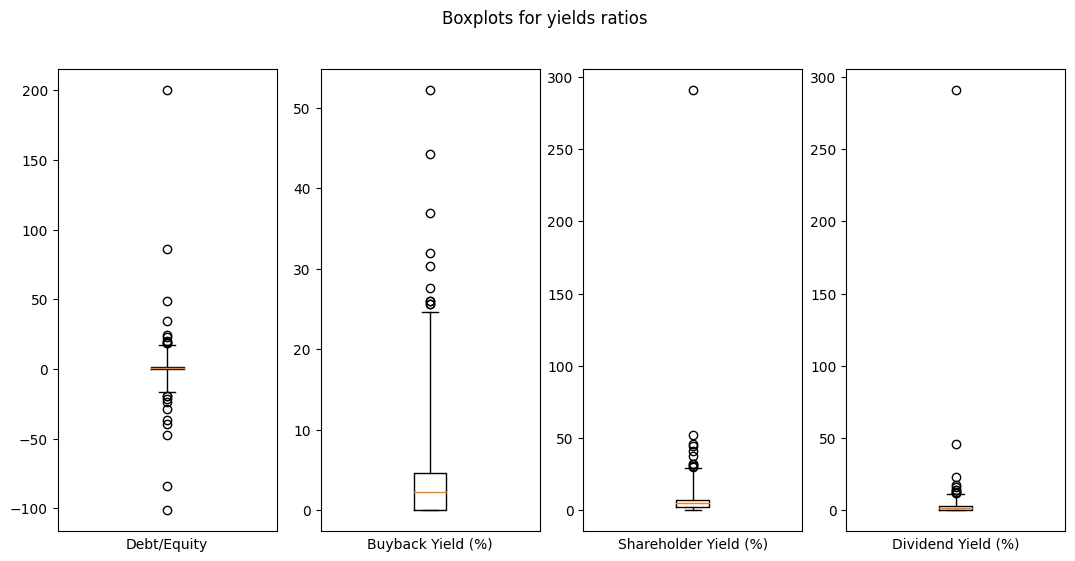

In [14]:
# debt to equity and yields ratios
yields_ratios = [
    'Debt/Equity', 'Buyback Yield (%)', 
    'Shareholder Yield (%)', 'Dividend Yield (%)'
]

# create a figure and ax
fig, ax = plt.subplots(1, 4, figsize=(13,6))

# create all the boxplots
for n in range(len(yields_ratios)):
    ax[n].boxplot(df[yields_ratios[n]], whis=(1,99)) # set the whiskers to top and lowest percentile
    ax[n].set_xlabel(yields_ratios[n])
    ax[n].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)

# title for all plots
fig.suptitle('Boxplots for yields ratios')

plt.show()

### Observations
Based on the above boxplots, it seems all these columns contains outliers, making the interquartile range (distance between the first and third quartile) quite small in most cases. There are some values that are still quite far from the lowest and highest percentile and I will remove these.

In [15]:
# join the two lists
ratios = yields_ratios + e_ratios

# lowest percentile for each ratio
percentile_1 = {
    ratio: df[ratio].quantile(0.01) for ratio in ratios
}

# highest percentile for each ratio
percentile_99 = {
    ratio: df[ratio].quantile(0.99) for ratio in ratios
}

# removing the outliers (below the lowest percentile and above the highest one)
for ratio in ratios:
    df.drop(df[df[ratio] < percentile_1[ratio]].index, inplace=True)
    df.drop(df[df[ratio] > percentile_99[ratio]].index, inplace=True)

# resetting index to the original integer index
df.reset_index(inplace=True, drop=True)

In [16]:
df.shape

(907, 16)

89 rows were removed, which is about 9% of the dataset. It's not insignificant, however, I believe this will result in better modelling later on.

With the outliers and infinity values removed, I am now ready to scale the remaining data.

In [17]:
# scaling
from sklearn.preprocessing import StandardScaler

features = df.drop(columns=['Ticker', 'overperformer']).columns
target = 'overperformer'

df_names = df[['Ticker', 'overperformer']]
df_numeric = df[features]
y = df[target]
 
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(
    df_numeric), index=df_numeric.index, columns=df_numeric.columns
)

### A note on Data leakage
Scaling the data first and splitting it only after this step will obviously result in data leakage (since the testing data is scaled together with the training data). This is, however, the same result I would get if I first joined the test data with the training data and scaled after, and predicted on the testing data. 

The reason why I opted to do it this way instead of scaling training and testing data separately is that stocks don't exist in vaccum. For instance, while a stock in the testing data could have the best Price to Earnings ratio, it could still be only average when compared to the whole group of stocks.

The other option, joining and scaling, would be something like this:
```
test_index = test.index
df_to_scale = pd.concat([test, train])
df_scaled = scaler.fit_transform(df_to_scale)
test_scaled = df_scaled[test_index]
```
This would lead me to the same level of scaling as doing it beforehand, so it's not an actual data leakage.


## Splitting test and train data

In [18]:
# import train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

## Selecting the best models using Grid Search

In [19]:
# importing grid search and models
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# select the best model based on grid search with cross validation
def select_model(df, features):
        # In a previous version of this notebook, I used a logistic regression # model as well as a random forests classifier. The one with the best # results was the KNeighborsClassifier. For that reason, I will use 
        # GridSearchCV to select the best parameters for this model.
    models = [
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(15,35,1),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "leaf_size": range(1,20,1), 
                    "p": [1,2]
                }
        }
    ]
    for model in models:
        print(model['name'])
        clf = GridSearchCV(model['estimator'], model['hyperparameters'], cv=10)
        clf.fit(X_train, y_train)
        model['best_params'] = clf.best_params_
        model['best_score'] = clf.best_score_
        model['best_model'] = clf.best_estimator_
        
        print(f"Best score: {model['best_score']}")
        print(f"Best parameters: {model['best_params']}\n")
        
    return models
    
train = pd.DataFrame(X_train, columns=features)
result = select_model(train, features)

KNeighborsClassifier
Best score: 0.7296423135464231
Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 34, 'p': 2, 'weights': 'distance'}



In [27]:
# calculate the accuracy of predictions per model
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

predictions = result[0]['best_model'].predict(X_test)
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

print(f"Accuracy of {result[0]['name']}: {accuracy}")
print(f"Precision of {result[0]['name']}: {precision}")
print(f"Recall of {result[0]['name']}: {recall}")

Accuracy of KNeighborsClassifier: 0.6978021978021978
Precision of KNeighborsClassifier: 1.0
Recall of KNeighborsClassifier: 0.03508771929824561


In [33]:
fp

0

## Observations
Since the accuracy of the model in training data and test data is similar (around 70%), I can conclude the model is not overfitting. 